# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    resonator_spectroscopy_g_vs_e,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

## 2. Set-up


### Emulation Mode


In [2]:
emulate = False

### Database Set-up


In [3]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [4]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [5]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748913649.5451813,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=258787878.787879,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=258787878.787879,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': Sign

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [6]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.25 15:06:43.443 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.25 15:06:43.443 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:06:43.443 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:06:43.498 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:06:44.970 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:06:45.113 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [42]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)
session.connect(do_emulation=False, reset_devices=True)
compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.25 13:16:37.696 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 13:16:37.697 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 13:16:37.703 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 13:16:39.096 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 13:16:39.238 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 13:16:39.435 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 13:16:39.588 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 13:16:39.713 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.25 13:16:39.714 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.25 13:16:39.714 laboneq.compiler.workflow.co

Text(0.5, 1.0, 'CW resonator spectroscopy, large range')

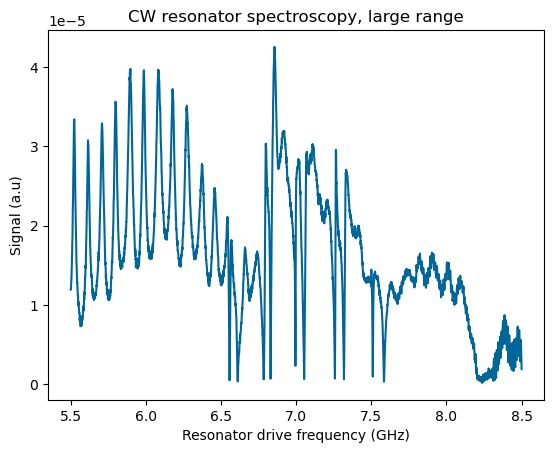

In [44]:
# access and plot results of one 8GHz sweep
gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep/1e9, np.array(flatten([data for data in gnd_signal])))
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, large range")

In [45]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

In [7]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 230e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
#plot_results(cw_spectroscopy_results)

2023.09.25 15:06:51.812 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:06:51.813 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:06:51.820 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:06:53.269 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:06:53.479 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:06:53.730 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:06:53.740 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:06:53.756 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.25 15:06:53.757 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.25 15:06:53.757 laboneq.compiler.workflow.co

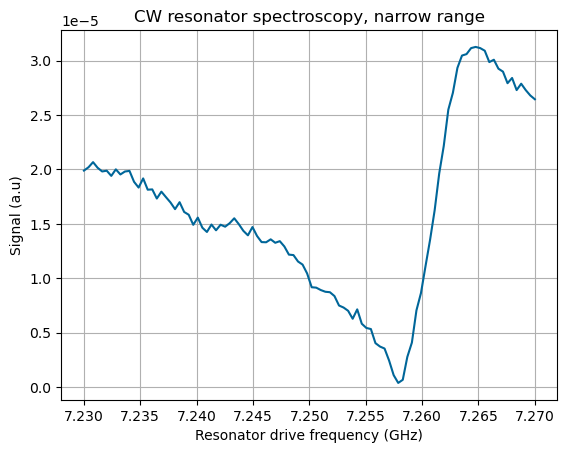

In [8]:
lo_frequency = cw_spectroscopy_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))
full_sweep = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, narrow range")
plt.grid()

In [12]:
#analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [10]:
first_readout_res = lo_frequency + 0.26e9
print(first_readout_res)

7260000000.0


In [11]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

# Spectroscopy vs Power - "Punchout" NOT TESTED


2023.09.25 12:36:52.510 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 12:36:52.511 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 12:36:52.517 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 12:36:53.911 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 12:36:54.056 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 12:36:54.288 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 12:36:54.375 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 12:36:54.704 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 23
2023.09.25 12:36:54.705 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8000
2023.09.25 12:36:54.706 laboneq.compiler.workflow

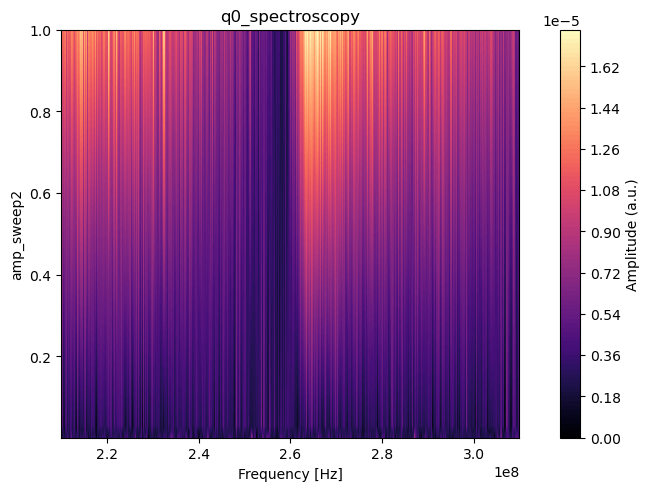

In [15]:
if True:
    freq_upper = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        + 50e6
    )
    freq_lower = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        - 50e6
    )

    amp_sweep = SweepParameter(
        uid="amp_sweep2",
        values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=3),
    )

    punchout = res_spectroscopy_pulsed_amp_sweep(
        qubit=transmon_list[0],
        integration_kernel=integration_kernel,
        readout_pulse=readout_gauss_square_pulse,
        frequency_sweep=create_freq_sweep(
            f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
        ),
        amplitude_sweep=amp_sweep,
        num_averages=2**8,
        measure_range=-25,
        acquire_range=-5,
    )

    session.connect(do_emulation=False, reset_devices=True)
    comp_punchout = session.compile(punchout)
    punchout_result = session.run(comp_punchout)

    plot_results(punchout_result)

In [14]:
if False:
    save_results(
        demo_results_db,
        punchout_result,
        "punchout",
        "neg_25_meas_neg_5_acq_range",
    )

In [15]:
if False:
    qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

    transmon_list = update_qubit_parameters_and_calibration(
        qubit_parameters, demo_setup, demo_setup_db
    )

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [9]:
def gen_const_pulse(qubit, length=5e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [10]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-25
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [11]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=6e6,
    qspec_num=251,
    num_averages=2**9,
)


In [12]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)
#plot_results(qspec_res)

2023.09.25 15:07:41.594 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:07:41.595 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:07:41.599 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:07:42.993 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:07:43.139 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:07:43.381 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:07:43.417 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:07:44.144 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.25 15:07:44.145 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8064
2023.09.25 15:07:44.145 laboneq.compiler.workflow

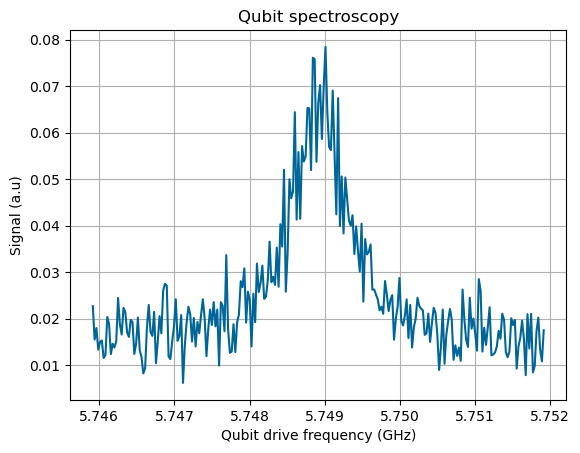

In [13]:
lo_frequency = qubit_parameters["qubits"]["q0"]["drive_lo_frequency"]["value"]

gnd_signal = abs(qspec_res.get_data("q0_spectroscopy"))
full_sweep = qspec_res.get_axis("q0_spectroscopy")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal)
plt.xlabel("Qubit drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("Qubit spectroscopy")
plt.grid()

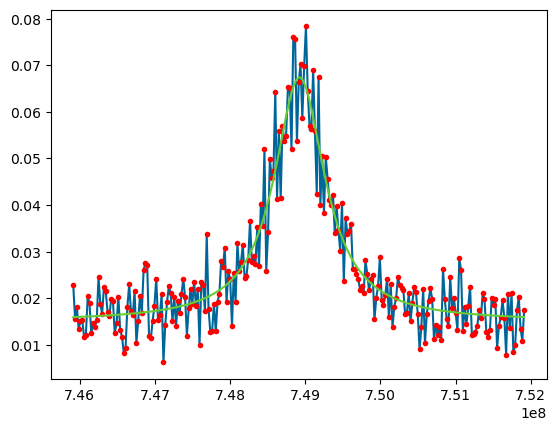

748924038.9486375


In [14]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.49e8,a=0.03,gamma=1E6, flip=False)
print(qubit_resonance)

### Update qubit resonance

In [22]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748913649.545181


# Amplitude Rabi

In [15]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [16]:
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi amplitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
                # qubit drive
                with exp_rabi.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_rabi.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit, amplitude=1),
                        amplitude=amplitude_sweep,
                    )
                # measurement
                with exp_rabi.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_rabi.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_rabi",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
        if cal_trace:
            with exp_rabi.section(uid="cal_trace_gnd_meas"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=1e-6, # qubit.parameters.user_defined["reset_delay_length"],
                )
            with exp_rabi.section(uid="cal_trace_exc", play_after="cal_trace_gnd_meas"):
                exp_rabi.play(
                    signal=f"drive_{qubit.uid}",
                    pulse=drive_pulse(qubit, amplitude = 1),
                    amplitude = pi_amplitude,
                )
                
            with exp_rabi.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                )
            

    return exp_rabi

In [17]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.25 15:08:17.044 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:08:17.052 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:08:17.082 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 188
2023.09.25 15:08:17.083 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8832
2023.09.25 15:08:17.084 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.25 15:08:17.085 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:08:17.086 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:08:17.092 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:08:18.565 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:08:18.708 laboneq.controller.devices.device

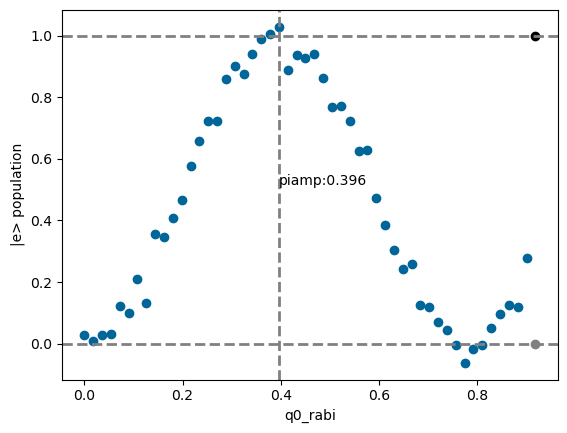

In [18]:
plot_with_trace_rabi(rabi_res)

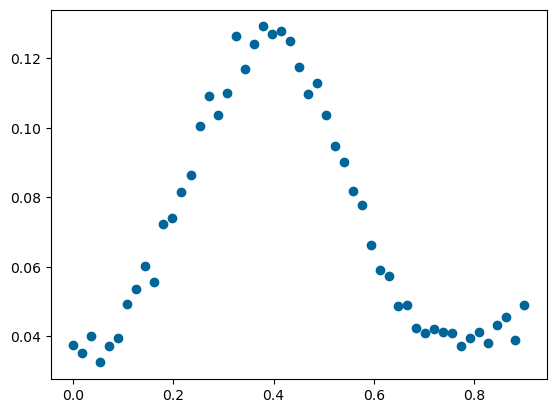

[0.07183919659456857, 1.5707963267948966, 0.04832967777126602, 0.32400000000000007]
[0.07817754 1.64815984 0.04502832 0.37970794]
Pi amp: 0.38907421875000003, pi/2 amp: 0.1991725639343262


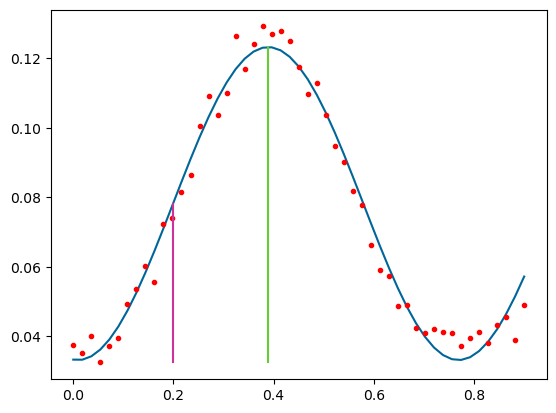

In [27]:
[pi_amp, pi2_amp] = evaluate_rabi(rabi_res, "q0_rabi")

In [28]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = float(pi_amp)
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = float(pi2_amp)


transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## T1 measurement

In [51]:
delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)

t1_meas = t1_parallel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=2**10,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.09.25 14:12:38.383 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 14:12:38.411 laboneq.compiler.scheduler.scheduler INFO   Schedule completed


2023.09.25 14:12:38.531 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 313
2023.09.25 14:12:38.531 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.25 14:12:38.532 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.25 14:12:38.533 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 14:12:38.534 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 14:12:38.538 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 14:12:39.874 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 14:12:40.019 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 14:12:40.931 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.25 14:12:41.316 laboneq.controller.

T1 found to be 25.140 us.


2.5140469559427195e-05

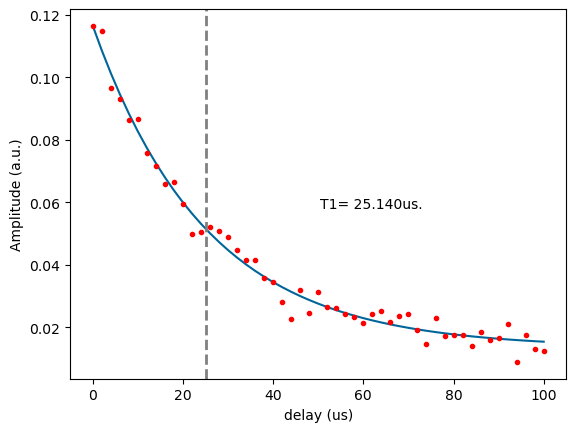

In [52]:
evaluate_T1(t1_res, "q0_t1")

## Ramsey

In [31]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    detuning = 0,
    cal_trace=False,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )


    

 #   readout_weight = readout_pulse
    freq = qubits[0].parameters.resonance_frequency_ge + detuning - qubits[0].parameters.drive_lo_frequency
  #  else:
   #     freq = detuning
         
    
    calibration = Calibration()   
    calibration["drive_q0"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq,
            modulation_type=ModulationType.HARDWARE
        )
    )

    exp_ramsey.set_calibration(calibration)

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
                if cal_trace:
                    with exp_ramsey.section(uid="cal_trace_gnd"):
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=1e-6 # qubit.parameters.user_defined["reset_delay_length"],
                        )
                    with exp_ramsey.section(uid="cal_trace_exc"):
                        exp_ramsey.play(
                            signal=f"drive_{qubit.uid}",
                            pulse=drive_pulse(qubit),
                            amplitude=qubits[0].parameters.user_defined['amplitude_pi'],
                        )
                        
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )

    return exp_ramsey

In [32]:
qubit_parameters["qubits"]["q0"]["reset_delay_length"]["value"] = 100e-6
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [33]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

### Set detuning freq

In [34]:
detuning_freq = .3e6

In [35]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=40e-6, count=151)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, detuning=detuning_freq, cal_trace=False)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.25 12:39:49.406 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 12:39:49.406 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 12:39:49.411 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 12:39:50.788 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 12:39:50.984 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 12:39:51.182 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 12:39:51.221 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 12:39:51.311 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 934
2023.09.25 12:39:51.311 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 10496
2023.09.25 12:39:51.312 laboneq.compiler.workfl

[0.07937448426046177, 1.5707963267948966, 0.04051224382002194, 3.2000000000000003e-06, 1e-05]
Detuned by 0.2793017349394123 MHz; T2 found to be 17.58760708902987 us.


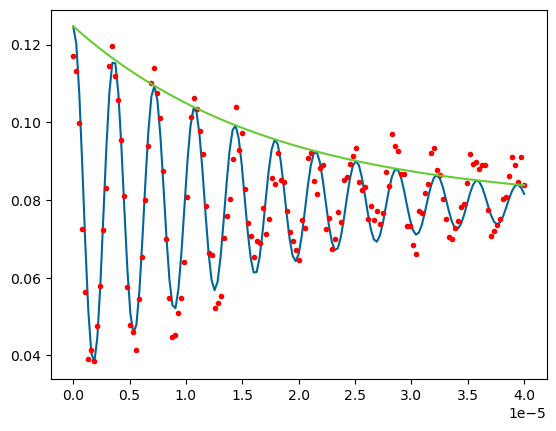

In [36]:
[t2, detuning_freq_measured] = evaluate_ramsey(res_ramsey, 'q0_ramsey')

# Active reset

## Optimize resonance freq

In [19]:
# resonator_spectroscopy gnd
gnd_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = None,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_g", 240e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**13,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_gnd_cw = session.compile(gnd_cw)
show_pulse_sheet("gnd_cw", compiled_gnd_cw)
gnd_cw_results = session.run(compiled_gnd_cw)

2023.09.25 15:08:48.133 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:08:48.134 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:08:48.139 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:08:49.522 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:08:49.663 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:08:49.857 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:08:49.872 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:08:49.903 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 24
2023.09.25 15:08:49.903 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8000
2023.09.25 15:08:49.904 laboneq.compiler.workflow

In [20]:
# resonator_spectroscopy_pi
excitation_cw = resonator_spectroscopy_g_vs_e(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_gauss_square_pulse,
    integration_kernel=integration_kernel,
    frequency_sweep = create_freq_sweep(f"{transmon_list[0].uid}_sweep_e", 240e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**10,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_excitation_cw = session.compile(excitation_cw)
show_pulse_sheet("exc_cw", compiled_excitation_cw)
excitation_cw_results = session.run(compiled_excitation_cw)

2023.09.25 15:08:54.949 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:08:54.950 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:08:54.955 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:08:56.323 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:08:56.465 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:08:56.723 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:08:56.751 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:08:56.796 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.25 15:08:56.797 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.25 15:08:56.797 laboneq.compiler.workflow

## Plotting

In [23]:
lo_frequency = gnd_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

gnd_signal = abs(gnd_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep = gnd_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency



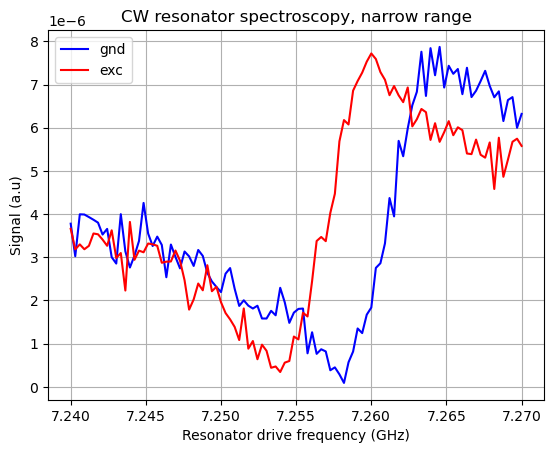

In [24]:
lo_frequency2 = excitation_cw_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

exc_signal = abs(excitation_cw_results.get_data("resonator_spectroscopy_q0"))
full_sweep2 = excitation_cw_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

plt.plot(full_sweep/1e9, gnd_signal, label="gnd",color='blue')
plt.plot(full_sweep2/1e9, exc_signal, label="exc", color='red')
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, narrow range")
plt.legend()
plt.grid()

In [25]:
diff_res_signal = abs(exc_signal - gnd_signal)
max_res_signal = np.max(diff_res_signal)
opt_res_freq = full_sweep[np.argmax(diff_res_signal)]
print(f"Optimized res freq {opt_res_freq/1e9} GHz gives max signal {max_res_signal}")

Optimized res freq 7.258181818181818 GHz gives max signal 6.087167453320955e-06


In [27]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = float(opt_res_freq)

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Optimize kernels

In [28]:
from laboneq.contrib.example_helpers.feedback_helper import (
    complex_freq_phase,
    exp_raw,
    exp_integration,
    exp_discrimination,
)

In [76]:
def exp_ref_trace(
    qubit,
    drive_pulse,
    readout_pulse,
    measure_range=-25,
    acquire_range=-25,
    acquire_length = 5e-6,
    num_averages=2**8,
    set_lo=False,
    lo_freq=None,
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Exp_ref_trace",
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    measure_pulse = readout_pulse(qubit)
    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        acquisition_type=AcquisitionType.RAW,
        #acquisition_type=AcquisitionType.INTEGRATION,
    ):
        if drive_pulse is None:
            print("drive pulse is None, assuming gnd, only readout")
            with exp_spec.section(uid=f"raw_{qubit.uid}_g"):
                # resonator signal readout
                # exp_spec.measure(
                #         measure_signal=f"measure_{qubit.uid}",
                #         measure_pulse=measure_pulse,
                #         handle=f"raw_{qubit.uid}",
                #         acquire_signal=f"acquire_{qubit.uid}",
                #         integration_length = measure_pulse.length,
                #         reset_delay=1e-6,
                #     )
                exp_spec.play(signal=f"measure_{qubit.uid}", pulse=measure_pulse)
                exp_spec.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", length=measure_pulse.length)
                #exp_spec.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", kernel=measure_pulse)
                exp_spec.delay(signal=f"measure_{qubit.uid}", time=10e-6)

            # with exp_spec.section(uid=f"delay_{qubit.uid}_g", length=1e-6):
            #     exp_spec.reserve(signal=f"measure_{qubit.uid}")
            #     exp_spec.reserve(signal=f"acquire_{qubit.uid}")

        # excited
        else:
            with exp_spec.section(uid="excitation"):
                exp_spec.play(signal=f"drive_{qubit.uid}", pulse = drive_pulse(qubit))
            with exp_spec.section(uid=f"raw_{qubit.uid}_e",play_after="excitation"):
                # resonator signal readout
                # exp_spec.measure(
                #         measure_signal=f"measure_{qubit.uid}",
                #         measure_pulse=measure_pulse,
                #         handle=f"raw_{qubit.uid}",
                #         acquire_signal=f"acquire_{qubit.uid}",
                #         integration_length=measure_pulse.length,
                #         reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                #     )
                exp_spec.play(signal=f"measure_{qubit.uid}", pulse=measure_pulse)
                exp_spec.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", length=measure_pulse.length)
                exp_spec.delay(signal=f"measure_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])
                #exp_spec.acquire(signal=f"acquire_{qubit.uid}", handle=f"raw_{qubit.uid}", kernel=measure_pulse)
            #     exp_spec.delay(signal=f"measure_{qubit.uid}", time=qubit.parameters.user_defined["reset_delay_length"])
            # with exp_spec.section(uid=f"delay_{qubit.uid}_e",length =1e-6):
            #     exp_spec.reserve(signal=f"measure_{qubit.uid}")
            #     exp_spec.reserve(signal=f"acquire_{qubit.uid}")

    cal = Calibration()
    if set_lo and lo_freq is not None:
        local_oscillator = Oscillator(frequency=lo_freq)
    else:
        local_oscillator = Oscillator(frequency=qubit.parameters.readout_lo_frequency)

    cal[f"measure_{qubit.uid}"] = SignalCalibration(
        local_oscillator=local_oscillator,
        range=measure_range,
    )
    cal[f"acquire_{qubit.uid}"] = SignalCalibration(
        local_oscillator=local_oscillator,
        range=acquire_range,
        port_delay=250e-9,
    )
    exp_spec.set_calibration(cal)

    return exp_spec

In [80]:
# resonator_spectroscopy gnd
gnd_ref = exp_ref_trace(
    transmon_list[0],
    drive_pulse = None,
    readout_pulse=readout_pulse,
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**13,
)
session.connect(do_emulation=False, reset_devices=True)

gnd_ref_results = session.run(gnd_ref)
show_pulse_sheet("gnd_ref", gnd_ref_results.compiled_experiment)

drive pulse is None, assuming gnd, only readout
2023.09.25 15:34:56.745 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:34:56.746 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:34:56.753 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:34:58.176 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:34:58.319 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:34:58.571 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:34:58.580 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:34:58.590 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 10
2023.09.25 15:34:58.591 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4000
2

c:\Users\ZI_at_PSI\code\Tune_up_scripts\gnd_ref_2023-09-25-15-35-00.html

In [81]:
# resonator_spectroscopy gnd
exc_ref = exp_ref_trace(
    transmon_list[0],
    drive_pulse = qubit_drive_pulse,
    readout_pulse=readout_pulse,
    measure_range=-25,
    acquire_range=-5,
    num_averages=2**13,
)
session.connect(do_emulation=False, reset_devices=True)
exc_ref_results = session.run(exc_ref)
show_pulse_sheet("exc_ref", exc_ref_results.compiled_experiment)

2023.09.25 15:35:30.748 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:35:30.749 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:35:30.756 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:35:32.206 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:35:32.351 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:35:32.587 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:35:32.593 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:35:32.604 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 20
2023.09.25 15:35:32.605 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 4416
2023.09.25 15:35:32.605 laboneq.compiler.workflow

c:\Users\ZI_at_PSI\code\Tune_up_scripts\exc_ref_2023-09-25-15-35-34.html

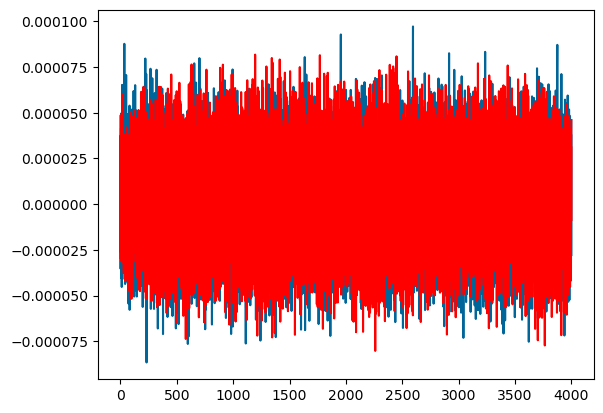

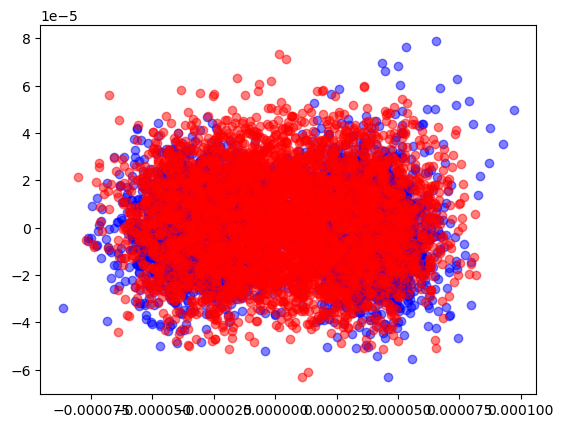

In [79]:
## Raw |0>
g_raw = gnd_ref_results.get_data("raw_q0")
e_raw = exc_ref_results.get_data("raw_q0")
#plt.scatter(g_raw.real, g_raw.imag, c="b", alpha=0.5)
#plt.scatter(e_raw.real, e_raw.imag, c="r", alpha=0.5)
plt.plot(np.real(g_raw))
plt.plot(np.real(e_raw))
plt.figure()
plt.scatter(g_raw.real, g_raw.imag, c="b", alpha=0.5)
plt.scatter(e_raw.real, e_raw.imag, c="r", alpha=0.5)
#plt.plot(exc_ref_results.get_data("raw_q0"))

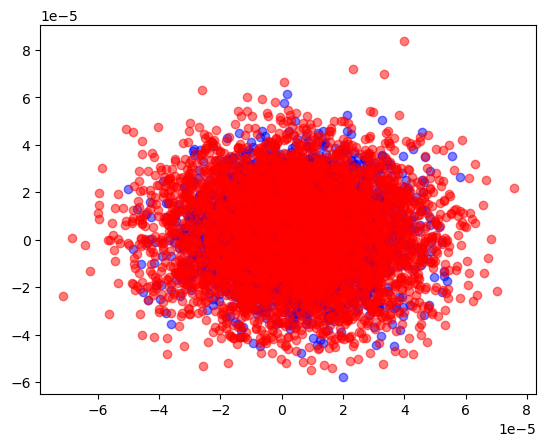

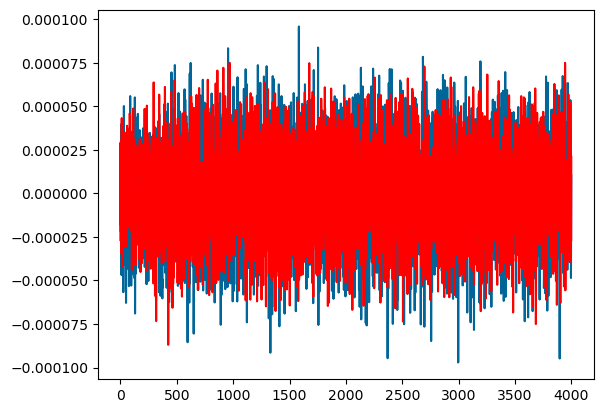

In [33]:

samples_kernel = np.conj(e_raw - g_raw)
plt.figure()
plt.plot(samples_kernel.real)
plt.plot(samples_kernel.imag)

In [58]:
def exp_int(
    qubit,
    drive_pulse,
    readout_pulse,
    integration_kernel,
    num_averages=2**8,
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_int = Experiment(
        uid="Exp_integration",
        signals=[
            ExperimentSignal(f"measure_{qubit.uid}", map_to=qubit.signals["measure"]),
            ExperimentSignal(f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]),
            ExperimentSignal(f"drive_{qubit.uid}", map_to=qubit.signals["drive"]),
        ],
    )
    try:
        integration_kernel= integration_kernel(qubit)
    except Exception as e:
        print(e)
        integration_kernel = integration_kernel
    with exp_int.acquire_loop_rt(
        uid="shots",
        count=num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        #acquisition_type=AcquisitionType.RAW,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp_int.section():
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=readout_pulse(qubit),
                handle=f"{qubit.uid}_int_g",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=10e-6,
            )
        with exp_int.section():
            exp_int.play(signal=f"drive_{qubit.uid}", pulse = drive_pulse(qubit))
            exp_int.measure(
                measure_signal=f"measure_{qubit.uid}",
                measure_pulse=readout_pulse(qubit),
                handle=f"{qubit.uid}_int_e",
                acquire_signal=f"acquire_{qubit.uid}",
                integration_kernel=integration_kernel,
                reset_delay=qubit.parameters.user_defined["reset_delay_length"],
            )
    return exp_int


In [59]:
do_rotation = True
rotation_angle=0
integration_kernel = pulse_library.sampled_pulse_complex(
        samples_kernel * np.exp(1j * rotation_angle)
    )
integration_kernel = readout_pulse
my_exp = exp_int(
    transmon_list[0],
    qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    num_averages=2**10,
)
    
session.connect(do_emulation=False, reset_devices=True)
res_int = session.run(my_exp)


2023.09.25 15:23:16.526 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.25 15:23:16.527 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.25 15:23:16.537 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.25 15:23:17.960 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.25 15:23:18.107 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.25 15:23:18.308 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.25 15:23:18.317 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.25 15:23:18.338 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 22
2023.09.25 15:23:18.338 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.25 15:23:18.340 laboneq.compiler.workflow

Using threshold = 2.857968e-02 and rotation angle: 2.076661e-01


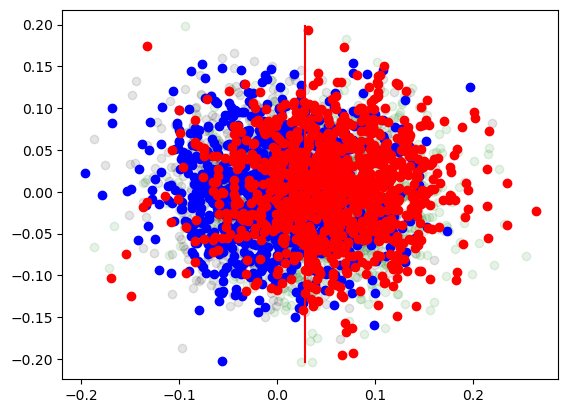

In [61]:
res0 = res_int.get_data("q0_int_g")
res1 = res_int.get_data("q0_int_e")

connect_vector = np.median(res1) - np.median(res0)
if do_rotation:
    rotation_angle = -np.angle(connect_vector)
else:
    rotation_angle = 0

res0_rot = res0 * np.exp(1j * rotation_angle)
res1_rot = res1 * np.exp(1j * rotation_angle)

my_threshold = (np.median(res0_rot.real) + np.median(res1_rot.real)) / 2

if do_rotation:
    plt.scatter(res0.real, res0.imag, c="k", alpha=0.1)
    plt.scatter(res1.real, res1.imag, c="g", alpha=0.1)

plt.scatter(res0_rot.real, res0_rot.imag, c="b")
plt.scatter(res1_rot.real, res1_rot.imag, c="r")
plt.plot(
    [my_threshold, my_threshold],
    [
        min([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
        max([*res0_rot.imag, *res1_rot.imag, *res0.imag, *res1.imag]),
    ],
    "r",
)
if do_rotation:
    print(f"Using threshold = {my_threshold:e} and rotation angle: {rotation_angle:e}")
else:
    print(f"Using threshold={my_threshold:e}")

# plt.figure()
# plt.hist(res0_rot.real, bins=100, alpha=0.5)
# plt.hist(res1_rot.real, bins=100, alpha=0.5)